In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import datetime

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from tensorflow.keras.preprocessing.image import load_img, img_to_array

import pickle

In [2]:
inicio = datetime.datetime.today()

In [3]:
print(tf. __version__)

2.6.2


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## TensorBoard

In [5]:
# log_directory = 'logs\\fit_' + datetime.datetime.now().strftime("%Y-%m-%d--%H-%M")
# board = TensorBoard(log_dir=log_directory,histogram_freq=1,
#     write_graph=True,
#     write_images=True,
#     update_freq='epoch',
#     profile_batch=2,
#     embeddings_freq=1)

In [6]:
# pwd

tensorboard --logdir logs\fit 

http://localhost:6006/#scalars

## Import Dataset

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [7]:
data_dir = 'C:\\Users\\andre\\Documents\\Datasets\\flower_photos'

In [8]:
total_imagenes = 0
for i in os.scandir(data_dir):
    if i.is_dir():
        print(f'La carpeta {i.name} tiene {len(os.listdir(i))} imagenes')
        total_imagenes += len(os.listdir(i))
print('------------')
print(f'El total de imagenes es {total_imagenes}')

La carpeta daisy tiene 633 imagenes
La carpeta dandelion tiene 898 imagenes
La carpeta roses tiene 641 imagenes
La carpeta sunflowers tiene 699 imagenes
La carpeta tulips tiene 799 imagenes
------------
El total de imagenes es 3670


In [9]:
roses = os.listdir(data_dir+'/roses')
roses = [data_dir + '/roses/' + flower for flower in roses] 

In [10]:
imread(roses[0]).shape

(240, 179, 3)

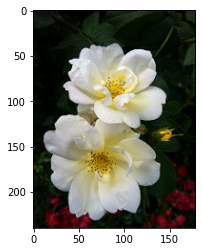

In [11]:
plt.imshow(imread(roses[0]))

# Data Pre-processing

## Finding the best shape

In [12]:
counter = 0
dim1 = []
dim2 = []
colors_temp = []
for i in os.scandir(data_dir):
    if i.is_dir():
        actual = os.listdir(data_dir+'/' + i.name)
        for j in actual:
            counter +=1
            img = imread(data_dir + '/' + i.name + '/' + j)
            d1,d2,colors = img.shape
            dim1.append(d1)
            dim2.append(d2)
            colors_temp.append(colors)
            

In [13]:
print(counter)
print(np.array(dim1).mean())
print(np.array(dim2).mean())
print(pd.Series(colors_temp).unique())

3670
271.79128065395093
365.0623978201635
[3]


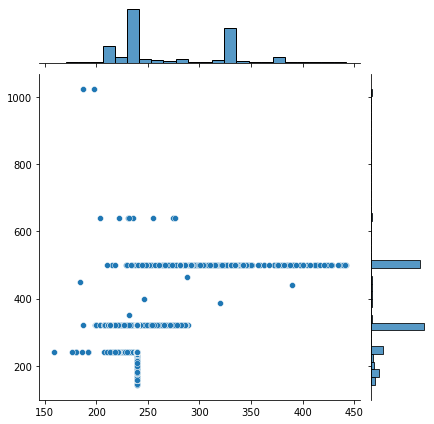

In [14]:
sns.jointplot(x = dim1,y = dim2)

## Train/Test Split

In [15]:
## Cambiarlo al promedio
batch_size = 32
img_height = 271
img_width = 365

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [18]:
# Experimento para hacer lo mismo de arriba en un solo paso
# train_ds_e, val_ds_e = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="both",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)


In [19]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


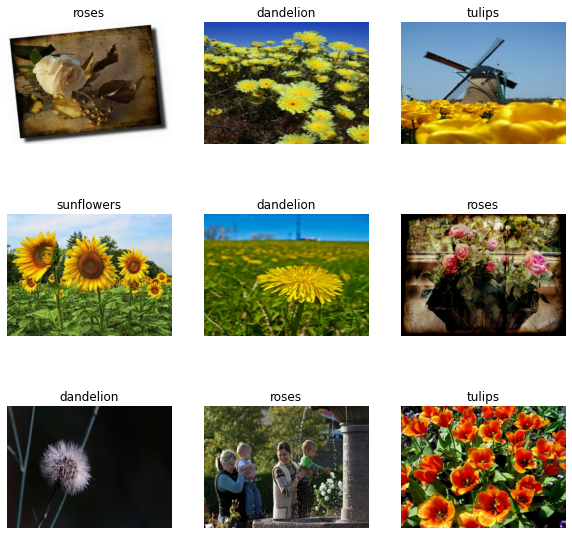

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [21]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 271, 365, 3)
(32,)


## Configure the dataset for performance

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the Model

In [23]:
num_classes = 5

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Rescaling(1./255))
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(num_classes))

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [24]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=600, 
#     use_multiprocessing = True
)

Epoch 1/600
92/92 [==============================] - 10s 78ms/step - loss: 1.4137 - accuracy: 0.4097 - val_loss: 1.0734 - val_accuracy: 0.5599
Epoch 2/600
92/92 [==============================] - 5s 59ms/step - loss: 0.9972 - accuracy: 0.6172 - val_loss: 1.0309 - val_accuracy: 0.5858
Epoch 3/600
92/92 [==============================] - 5s 59ms/step - loss: 0.6890 - accuracy: 0.7391 - val_loss: 1.0637 - val_accuracy: 0.5790
Epoch 4/600
92/92 [==============================] - 8s 83ms/step - loss: 0.4066 - accuracy: 0.8546 - val_loss: 1.3155 - val_accuracy: 0.5886
Epoch 5/600
92/92 [==============================] - 9s 101ms/step - loss: 0.3227 - accuracy: 0.8883 - val_loss: 1.4564 - val_accuracy: 0.5954
Epoch 6/600
92/92 [==============================] - 5s 58ms/step - loss: 0.2448 - accuracy: 0.9189 - val_loss: 1.7021 - val_accuracy: 0.5845
Epoch 7/600
92/92 [==============================] - 5s 59ms/step - loss: 0.2338 - accuracy: 0.9217 - val_loss: 1.7391 - val_accuracy: 0.5586
Epoc

92/92 [==============================] - 5s 59ms/step - loss: 6.5390e-06 - accuracy: 1.0000 - val_loss: 3.9882 - val_accuracy: 0.6294
Epoch 58/600
92/92 [==============================] - 5s 59ms/step - loss: 6.0751e-06 - accuracy: 1.0000 - val_loss: 4.0043 - val_accuracy: 0.6308
Epoch 59/600
92/92 [==============================] - 5s 59ms/step - loss: 5.7183e-06 - accuracy: 1.0000 - val_loss: 4.0187 - val_accuracy: 0.6308
Epoch 60/600
92/92 [==============================] - 5s 59ms/step - loss: 5.3119e-06 - accuracy: 1.0000 - val_loss: 4.0337 - val_accuracy: 0.6322
Epoch 61/600
92/92 [==============================] - 5s 59ms/step - loss: 4.9863e-06 - accuracy: 1.0000 - val_loss: 4.0486 - val_accuracy: 0.6322
Epoch 62/600
92/92 [==============================] - 5s 59ms/step - loss: 4.6694e-06 - accuracy: 1.0000 - val_loss: 4.0629 - val_accuracy: 0.6294
Epoch 63/600
92/92 [==============================] - 5s 59ms/step - loss: 4.3531e-06 - accuracy: 1.0000 - val_loss: 4.0769 - val_a

Epoch 113/600
92/92 [==============================] - 5s 59ms/step - loss: 2.8645e-07 - accuracy: 1.0000 - val_loss: 4.7187 - val_accuracy: 0.6253
Epoch 114/600
92/92 [==============================] - 6s 68ms/step - loss: 2.7370e-07 - accuracy: 1.0000 - val_loss: 4.7310 - val_accuracy: 0.6253
Epoch 115/600
92/92 [==============================] - 7s 72ms/step - loss: 2.6018e-07 - accuracy: 1.0000 - val_loss: 4.7437 - val_accuracy: 0.6240
Epoch 116/600
92/92 [==============================] - 6s 65ms/step - loss: 2.4751e-07 - accuracy: 1.0000 - val_loss: 4.7558 - val_accuracy: 0.6240
Epoch 117/600
92/92 [==============================] - 6s 64ms/step - loss: 2.3610e-07 - accuracy: 1.0000 - val_loss: 4.7684 - val_accuracy: 0.6240
Epoch 118/600
92/92 [==============================] - 6s 71ms/step - loss: 2.2445e-07 - accuracy: 1.0000 - val_loss: 4.7801 - val_accuracy: 0.6240
Epoch 119/600
92/92 [==============================] - 6s 66ms/step - loss: 2.1422e-07 - accuracy: 1.0000 - val_

92/92 [==============================] - 5s 59ms/step - loss: 1.9814e-08 - accuracy: 1.0000 - val_loss: 5.3597 - val_accuracy: 0.6213
Epoch 169/600
92/92 [==============================] - 6s 60ms/step - loss: 1.9043e-08 - accuracy: 1.0000 - val_loss: 5.3683 - val_accuracy: 0.6226
Epoch 170/600
92/92 [==============================] - 5s 60ms/step - loss: 1.8231e-08 - accuracy: 1.0000 - val_loss: 5.3774 - val_accuracy: 0.6226
Epoch 171/600
92/92 [==============================] - 5s 59ms/step - loss: 1.7500e-08 - accuracy: 1.0000 - val_loss: 5.3860 - val_accuracy: 0.6240
Epoch 172/600
92/92 [==============================] - 5s 58ms/step - loss: 1.6850e-08 - accuracy: 1.0000 - val_loss: 5.3945 - val_accuracy: 0.6226
Epoch 173/600
92/92 [==============================] - 6s 70ms/step - loss: 1.6079e-08 - accuracy: 1.0000 - val_loss: 5.4037 - val_accuracy: 0.6226
Epoch 174/600
92/92 [==============================] - 6s 62ms/step - loss: 1.5307e-08 - accuracy: 1.0000 - val_loss: 5.4122 -

92/92 [==============================] - 17s 188ms/step - loss: 2.5580e-09 - accuracy: 1.0000 - val_loss: 5.5985 - val_accuracy: 0.6185
Epoch 224/600
92/92 [==============================] - 15s 167ms/step - loss: 2.3143e-09 - accuracy: 1.0000 - val_loss: 5.6052 - val_accuracy: 0.6172
Epoch 225/600
92/92 [==============================] - 17s 188ms/step - loss: 2.2331e-09 - accuracy: 1.0000 - val_loss: 5.6086 - val_accuracy: 0.6199
Epoch 226/600
92/92 [==============================] - 15s 166ms/step - loss: 2.2737e-09 - accuracy: 1.0000 - val_loss: 5.6166 - val_accuracy: 0.6172
Epoch 227/600
92/92 [==============================] - 17s 187ms/step - loss: 2.1519e-09 - accuracy: 1.0000 - val_loss: 5.6248 - val_accuracy: 0.6172
Epoch 228/600
92/92 [==============================] - 15s 167ms/step - loss: 2.0707e-09 - accuracy: 1.0000 - val_loss: 5.6323 - val_accuracy: 0.6185
Epoch 229/600
92/92 [==============================] - 17s 187ms/step - loss: 2.1113e-09 - accuracy: 1.0000 - val_

Epoch 278/600
92/92 [==============================] - 5s 59ms/step - loss: 3.2482e-10 - accuracy: 1.0000 - val_loss: 7.3696 - val_accuracy: 0.6076
Epoch 279/600
92/92 [==============================] - 5s 58ms/step - loss: 4.4663e-10 - accuracy: 1.0000 - val_loss: 7.4518 - val_accuracy: 0.6076
Epoch 280/600
92/92 [==============================] - 5s 59ms/step - loss: 1.6647e-09 - accuracy: 1.0000 - val_loss: 7.3978 - val_accuracy: 0.6213
Epoch 281/600
92/92 [==============================] - 5s 58ms/step - loss: 0.7561 - accuracy: 0.8031 - val_loss: 2.1855 - val_accuracy: 0.5123
Epoch 282/600
92/92 [==============================] - 5s 57ms/step - loss: 0.1981 - accuracy: 0.9448 - val_loss: 2.6461 - val_accuracy: 0.5627
Epoch 283/600
92/92 [==============================] - 5s 58ms/step - loss: 0.0669 - accuracy: 0.9864 - val_loss: 2.8038 - val_accuracy: 0.5804
Epoch 284/600
92/92 [==============================] - 5s 58ms/step - loss: 0.0213 - accuracy: 0.9963 - val_loss: 2.9263 - v

92/92 [==============================] - 5s 58ms/step - loss: 2.8197e-06 - accuracy: 1.0000 - val_loss: 4.3774 - val_accuracy: 0.5940
Epoch 334/600
92/92 [==============================] - 5s 58ms/step - loss: 2.6600e-06 - accuracy: 1.0000 - val_loss: 4.3869 - val_accuracy: 0.5940
Epoch 335/600
92/92 [==============================] - 5s 58ms/step - loss: 2.5083e-06 - accuracy: 1.0000 - val_loss: 4.3974 - val_accuracy: 0.5940
Epoch 336/600
92/92 [==============================] - 5s 58ms/step - loss: 2.3674e-06 - accuracy: 1.0000 - val_loss: 4.4070 - val_accuracy: 0.5940
Epoch 337/600
92/92 [==============================] - 5s 58ms/step - loss: 2.2341e-06 - accuracy: 1.0000 - val_loss: 4.4165 - val_accuracy: 0.5926
Epoch 338/600
92/92 [==============================] - 5s 58ms/step - loss: 2.1068e-06 - accuracy: 1.0000 - val_loss: 4.4265 - val_accuracy: 0.5926
Epoch 339/600
92/92 [==============================] - 5s 58ms/step - loss: 1.9878e-06 - accuracy: 1.0000 - val_loss: 4.4359 -

92/92 [==============================] - 6s 61ms/step - loss: 1.7029e-07 - accuracy: 1.0000 - val_loss: 4.9020 - val_accuracy: 0.5886
Epoch 389/600
92/92 [==============================] - 6s 61ms/step - loss: 1.6213e-07 - accuracy: 1.0000 - val_loss: 4.9122 - val_accuracy: 0.5886
Epoch 390/600
92/92 [==============================] - 6s 61ms/step - loss: 1.5514e-07 - accuracy: 1.0000 - val_loss: 4.9217 - val_accuracy: 0.5886
Epoch 391/600
92/92 [==============================] - 6s 61ms/step - loss: 1.4787e-07 - accuracy: 1.0000 - val_loss: 4.9313 - val_accuracy: 0.5886
Epoch 392/600
92/92 [==============================] - 6s 61ms/step - loss: 1.4053e-07 - accuracy: 1.0000 - val_loss: 4.9421 - val_accuracy: 0.5872
Epoch 393/600
92/92 [==============================] - 6s 61ms/step - loss: 1.3431e-07 - accuracy: 1.0000 - val_loss: 4.9522 - val_accuracy: 0.5858
Epoch 394/600
92/92 [==============================] - 6s 61ms/step - loss: 1.2847e-07 - accuracy: 1.0000 - val_loss: 4.9614 -

92/92 [==============================] - 5s 60ms/step - loss: 1.1775e-08 - accuracy: 1.0000 - val_loss: 5.4553 - val_accuracy: 0.5763
Epoch 444/600
92/92 [==============================] - 6s 62ms/step - loss: 1.1206e-08 - accuracy: 1.0000 - val_loss: 5.4661 - val_accuracy: 0.5763
Epoch 445/600
92/92 [==============================] - 6s 62ms/step - loss: 1.0475e-08 - accuracy: 1.0000 - val_loss: 5.4769 - val_accuracy: 0.5749
Epoch 446/600
92/92 [==============================] - 5s 58ms/step - loss: 1.0191e-08 - accuracy: 1.0000 - val_loss: 5.4890 - val_accuracy: 0.5736
Epoch 447/600
92/92 [==============================] - 6s 61ms/step - loss: 9.8258e-09 - accuracy: 1.0000 - val_loss: 5.4999 - val_accuracy: 0.5736
Epoch 448/600
92/92 [==============================] - 6s 62ms/step - loss: 9.0950e-09 - accuracy: 1.0000 - val_loss: 5.5108 - val_accuracy: 0.5736
Epoch 449/600
92/92 [==============================] - 5s 58ms/step - loss: 8.6890e-09 - accuracy: 1.0000 - val_loss: 5.5222 -

92/92 [==============================] - 5s 58ms/step - loss: 1.3805e-09 - accuracy: 1.0000 - val_loss: 6.5769 - val_accuracy: 0.5681
Epoch 499/600
92/92 [==============================] - 5s 58ms/step - loss: 1.4211e-09 - accuracy: 1.0000 - val_loss: 6.6166 - val_accuracy: 0.5681
Epoch 500/600
92/92 [==============================] - 5s 58ms/step - loss: 1.5429e-09 - accuracy: 1.0000 - val_loss: 6.6644 - val_accuracy: 0.5681
Epoch 501/600
92/92 [==============================] - 5s 58ms/step - loss: 1.2181e-09 - accuracy: 1.0000 - val_loss: 6.7108 - val_accuracy: 0.5668
Epoch 502/600
92/92 [==============================] - 5s 58ms/step - loss: 1.5023e-09 - accuracy: 1.0000 - val_loss: 6.7540 - val_accuracy: 0.5681
Epoch 503/600
92/92 [==============================] - 5s 58ms/step - loss: 1.3399e-09 - accuracy: 1.0000 - val_loss: 6.8063 - val_accuracy: 0.5668
Epoch 504/600
92/92 [==============================] - 5s 58ms/step - loss: 1.2993e-09 - accuracy: 1.0000 - val_loss: 6.8541 -

Epoch 554/600
92/92 [==============================] - 5s 57ms/step - loss: 1.0107e-05 - accuracy: 1.0000 - val_loss: 5.3775 - val_accuracy: 0.5913
Epoch 555/600
92/92 [==============================] - 5s 57ms/step - loss: 8.9403e-06 - accuracy: 1.0000 - val_loss: 5.4033 - val_accuracy: 0.5913
Epoch 556/600
92/92 [==============================] - 5s 57ms/step - loss: 7.9806e-06 - accuracy: 1.0000 - val_loss: 5.4300 - val_accuracy: 0.5913
Epoch 557/600
92/92 [==============================] - 5s 57ms/step - loss: 7.1573e-06 - accuracy: 1.0000 - val_loss: 5.4547 - val_accuracy: 0.5886
Epoch 558/600
92/92 [==============================] - 5s 57ms/step - loss: 6.4391e-06 - accuracy: 1.0000 - val_loss: 5.4785 - val_accuracy: 0.5886
Epoch 559/600
92/92 [==============================] - 5s 57ms/step - loss: 5.8258e-06 - accuracy: 1.0000 - val_loss: 5.5024 - val_accuracy: 0.5886
Epoch 560/600
92/92 [==============================] - 5s 57ms/step - loss: 5.2688e-06 - accuracy: 1.0000 - val_

## Evaluation

In [25]:
model.history.history

{'loss': [1.4137237071990967,
  0.9971816539764404,
  0.6889675259590149,
  0.4065970480442047,
  0.3226552903652191,
  0.2448319047689438,
  0.2338208556175232,
  0.171763077378273,
  0.1564570814371109,
  0.09179765731096268,
  0.03166188299655914,
  0.035632360726594925,
  0.032125964760780334,
  0.023454738780856133,
  0.012524121440947056,
  0.0030813494231551886,
  0.0011275401338934898,
  0.0007299883291125298,
  0.0005108184996061027,
  0.0003794449439737946,
  0.000286738621070981,
  0.00022767650079913437,
  0.00017474518972449005,
  0.00015287304995581508,
  0.00012126089131925255,
  0.00010431194823468104,
  8.804308163234964e-05,
  7.758650463074446e-05,
  6.871212099213153e-05,
  5.9797996073029935e-05,
  5.4144064051797614e-05,
  4.787494981428608e-05,
  4.364654159871861e-05,
  3.883434692397714e-05,
  3.58497018169146e-05,
  3.227429624530487e-05,
  2.966333704534918e-05,
  2.718936048040632e-05,
  2.5242607080144808e-05,
  2.3037759092403576e-05,
  2.1531726815737784e

<AxesSubplot:>

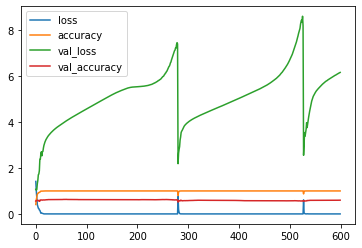

In [26]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [27]:
model.metrics_names

['loss', 'accuracy']

In [28]:
training_score = model.evaluate(train_ds,verbose=1)
test_score = model.evaluate(val_ds,verbose=1)

23/23 [==============================] - 0s 17ms/step - loss: 6.1569 - accuracy: 0.5981


In [29]:
print(training_score)
print(test_score)

[3.271333071097615e-07, 1.0]
[6.156871318817139, 0.5980926156044006]


In [30]:
predictions = model.predict(val_ds)

In [31]:
predictions

array([[-17.643759  ,  12.411552  , -13.520702  , -20.568203  ,
        -15.149525  ],
       [ -4.609145  , -32.512558  , -22.390814  ,   2.3300889 ,
         -7.505137  ],
       [-12.482118  ,  -9.247252  , -23.590649  ,   3.1195414 ,
          2.884437  ],
       ...,
       [ -6.2563934 , -15.2293215 ,  -8.897405  ,  -5.4705305 ,
        -17.490673  ],
       [ -0.19523099,  -5.1664696 , -39.06589   , -21.508497  ,
         -5.9516826 ],
       [-15.130856  ,  -0.45790055,  -7.064777  , -18.682526  ,
         -6.464307  ]], dtype=float32)

In [32]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [33]:
predictions = pd.Series(np.argmax(predictions,axis=1))

In [34]:
predictions

0      1
1      3
2      3
3      0
4      3
      ..
729    2
730    4
731    3
732    0
733    1
Length: 734, dtype: int64

In [35]:
predictions = pd.Series(predictions).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)

In [36]:
predictions

0       dandelion
1      sunflowers
2      sunflowers
3           daisy
4      sunflowers
          ...    
729         roses
730        tulips
731    sunflowers
732         daisy
733     dandelion
Length: 734, dtype: object

In [37]:
true_categories = tf.concat([y for x, y in val_ds], axis=0).numpy()

In [38]:
true_categories

array([0, 4, 3, 0, 3, 4, 1, 2, 4, 0, 0, 0, 4, 4, 4, 3, 3, 0, 0, 3, 1, 4,
       4, 2, 3, 3, 1, 2, 1, 2, 4, 1, 1, 0, 2, 2, 3, 1, 3, 4, 2, 3, 4, 4,
       3, 4, 4, 3, 4, 1, 4, 1, 4, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 1, 3, 1,
       0, 3, 4, 1, 0, 2, 3, 0, 3, 1, 0, 0, 3, 0, 4, 2, 3, 1, 4, 3, 1, 4,
       2, 1, 1, 0, 1, 2, 4, 2, 0, 2, 4, 3, 2, 1, 1, 2, 0, 0, 1, 4, 3, 0,
       4, 2, 0, 0, 0, 1, 0, 4, 4, 4, 0, 4, 4, 3, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 3, 0, 3, 4, 2, 3, 0, 3, 2, 2, 3, 2, 4, 3, 4, 0, 4, 2, 2, 0,
       2, 1, 0, 3, 2, 3, 0, 2, 4, 3, 0, 2, 3, 3, 4, 0, 1, 2, 3, 0, 4, 3,
       3, 1, 3, 2, 3, 1, 1, 2, 1, 4, 0, 1, 3, 3, 2, 2, 4, 1, 3, 1, 4, 1,
       1, 0, 1, 4, 3, 1, 1, 3, 3, 4, 1, 1, 0, 4, 1, 1, 1, 1, 3, 4, 3, 0,
       2, 2, 1, 4, 1, 1, 3, 1, 0, 0, 4, 4, 0, 1, 4, 3, 4, 4, 0, 2, 3, 3,
       3, 4, 0, 2, 4, 1, 1, 0, 1, 0, 3, 3, 4, 2, 0, 3, 4, 4, 1, 0, 2, 4,
       0, 2, 4, 4, 3, 1, 4, 2, 3, 3, 3, 3, 3, 1, 4, 4, 3, 2, 2, 3, 3, 0,
       3, 1, 1, 4, 4, 1, 4, 4, 3, 4, 0, 1, 1, 2, 0,

In [39]:
true_categories = pd.Series(true_categories).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)

In [40]:
true_categories

0           daisy
1          tulips
2      sunflowers
3           daisy
4      sunflowers
          ...    
729        tulips
730        tulips
731        tulips
732         daisy
733     dandelion
Length: 734, dtype: object

In [41]:
metrics.accuracy_score(predictions, true_categories)

0.5980926430517711

In [42]:
metrics.confusion_matrix(predictions, true_categories)

array([[ 69,  21,  13,   6,  16],
       [ 28, 120,   9,  21,  12],
       [ 12,   8,  59,   4,  31],
       [  4,  13,   3, 110,  17],
       [ 16,  14,  36,  11,  81]], dtype=int64)

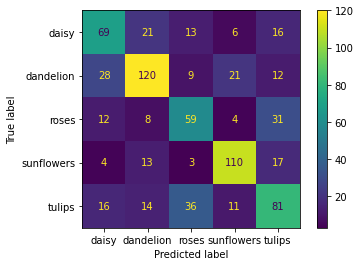

In [43]:
cm = metrics.confusion_matrix(predictions, true_categories)
metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_names).plot()

In [44]:
print(metrics.classification_report(predictions, true_categories))

              precision    recall  f1-score   support

       daisy       0.53      0.55      0.54       125
   dandelion       0.68      0.63      0.66       190
       roses       0.49      0.52      0.50       114
  sunflowers       0.72      0.75      0.74       147
      tulips       0.52      0.51      0.51       158

    accuracy                           0.60       734
   macro avg       0.59      0.59      0.59       734
weighted avg       0.60      0.60      0.60       734



In [45]:
final = datetime.datetime.today()

In [46]:
tiempo_transcurrido = final - inicio

In [47]:
tiempo_transcurrido.seconds

4165

In [48]:
tiempo_transcurrido.seconds/60

69.41666666666667

In [49]:
tiempo_transcurrido.seconds/(60*60)

1.1569444444444446

## Early Stopping

In [50]:
num_classes = 5

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Rescaling(1./255))
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(num_classes))

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [51]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [52]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=600, 
    use_multiprocessing = True,
    callbacks=[early_stop]
#     callbacks = [early_stop, board]
)

Epoch 1/600
92/92 [==============================] - 6s 59ms/step - loss: 1.3786 - accuracy: 0.4537 - val_loss: 1.1090 - val_accuracy: 0.5259
Epoch 2/600
92/92 [==============================] - 5s 58ms/step - loss: 1.0185 - accuracy: 0.5909 - val_loss: 1.1076 - val_accuracy: 0.5477
Epoch 3/600
92/92 [==============================] - 5s 58ms/step - loss: 0.8408 - accuracy: 0.6706 - val_loss: 1.0132 - val_accuracy: 0.6104
Epoch 4/600
92/92 [==============================] - 5s 58ms/step - loss: 0.6062 - accuracy: 0.7776 - val_loss: 1.0949 - val_accuracy: 0.6063
Epoch 5/600
92/92 [==============================] - 5s 58ms/step - loss: 0.4099 - accuracy: 0.8569 - val_loss: 1.6222 - val_accuracy: 0.5450
Epoch 6/600
92/92 [==============================] - 5s 58ms/step - loss: 0.3554 - accuracy: 0.8822 - val_loss: 1.3349 - val_accuracy: 0.6022
Epoch 7/600
92/92 [==============================] - 5s 58ms/step - loss: 0.2423 - accuracy: 0.9217 - val_loss: 1.7965 - val_accuracy: 0.5708
Epoch 

## Evaluation

In [53]:
model.history.history

{'loss': [1.378644585609436,
  1.0185290575027466,
  0.8408184051513672,
  0.6062071323394775,
  0.4098571836948395,
  0.3554135262966156,
  0.24229708313941956,
  0.18706971406936646,
  0.16619180142879486,
  0.131400465965271,
  0.10769519209861755,
  0.05939831957221031,
  0.023462112993001938,
  0.010700399056077003,
  0.004113663919270039,
  0.003892536973580718,
  0.018465282395482063,
  0.004777862224727869,
  0.0011503093410283327,
  0.000524515169672668,
  0.00038689302164129913,
  0.00030691534630022943,
  0.0002519532572478056,
  0.00021201228082645684,
  0.00018173579883296043,
  0.00015766339492984116,
  0.00013816767022944987,
  0.00012216456525493413],
 'accuracy': [0.4536784887313843,
  0.5909400582313538,
  0.6706403493881226,
  0.7775885462760925,
  0.8569482564926147,
  0.8821526169776917,
  0.9216621518135071,
  0.9455040693283081,
  0.9434604644775391,
  0.958106279373169,
  0.9645776748657227,
  0.9822888374328613,
  0.9938691854476929,
  0.9986376166343689,
  0.9

<AxesSubplot:>

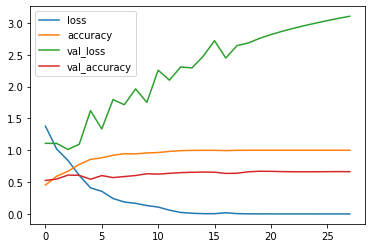

In [54]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [55]:
model.metrics_names

['loss', 'accuracy']

In [56]:
training_score = model.evaluate(train_ds,verbose=1)
test_score = model.evaluate(val_ds,verbose=1)

23/23 [==============================] - 0s 16ms/step - loss: 3.1054 - accuracy: 0.6635


In [57]:
print(training_score)
print(test_score)

[0.00011017182987416163, 1.0]
[3.105412483215332, 0.6634877324104309]


In [58]:
predictions = model.predict(val_ds)

In [59]:
predictions

array([[ -5.5332727,  16.306395 , -14.368464 , -10.896724 ,  -2.9532275],
       [  3.767542 ,  -7.55105  , -12.618816 ,   0.8811403,   3.23106  ],
       [ -6.7486715, -10.606495 , -13.735081 ,  18.089552 ,   5.564132 ],
       ...,
       [  3.4868655,   8.561354 ,  -4.4094424, -16.435556 ,  -4.737206 ],
       [ 15.166067 ,   3.2926476, -10.857545 ,  -8.935339 , -12.253768 ],
       [  1.1575297,   5.6838646,  -1.3873566, -15.290123 ,  -1.8351402]],
      dtype=float32)

In [60]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [61]:
predictions = pd.Series(np.argmax(predictions,axis=1))

In [62]:
predictions

0      1
1      0
2      3
3      0
4      3
      ..
729    4
730    4
731    1
732    0
733    1
Length: 734, dtype: int64

In [63]:
predictions = pd.Series(predictions).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)

In [64]:
predictions

0       dandelion
1           daisy
2      sunflowers
3           daisy
4      sunflowers
          ...    
729        tulips
730        tulips
731     dandelion
732         daisy
733     dandelion
Length: 734, dtype: object

In [65]:
true_categories = tf.concat([y for x, y in val_ds], axis=0).numpy()

In [66]:
true_categories

array([0, 4, 3, 0, 3, 4, 1, 2, 4, 0, 0, 0, 4, 4, 4, 3, 3, 0, 0, 3, 1, 4,
       4, 2, 3, 3, 1, 2, 1, 2, 4, 1, 1, 0, 2, 2, 3, 1, 3, 4, 2, 3, 4, 4,
       3, 4, 4, 3, 4, 1, 4, 1, 4, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 1, 3, 1,
       0, 3, 4, 1, 0, 2, 3, 0, 3, 1, 0, 0, 3, 0, 4, 2, 3, 1, 4, 3, 1, 4,
       2, 1, 1, 0, 1, 2, 4, 2, 0, 2, 4, 3, 2, 1, 1, 2, 0, 0, 1, 4, 3, 0,
       4, 2, 0, 0, 0, 1, 0, 4, 4, 4, 0, 4, 4, 3, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 3, 0, 3, 4, 2, 3, 0, 3, 2, 2, 3, 2, 4, 3, 4, 0, 4, 2, 2, 0,
       2, 1, 0, 3, 2, 3, 0, 2, 4, 3, 0, 2, 3, 3, 4, 0, 1, 2, 3, 0, 4, 3,
       3, 1, 3, 2, 3, 1, 1, 2, 1, 4, 0, 1, 3, 3, 2, 2, 4, 1, 3, 1, 4, 1,
       1, 0, 1, 4, 3, 1, 1, 3, 3, 4, 1, 1, 0, 4, 1, 1, 1, 1, 3, 4, 3, 0,
       2, 2, 1, 4, 1, 1, 3, 1, 0, 0, 4, 4, 0, 1, 4, 3, 4, 4, 0, 2, 3, 3,
       3, 4, 0, 2, 4, 1, 1, 0, 1, 0, 3, 3, 4, 2, 0, 3, 4, 4, 1, 0, 2, 4,
       0, 2, 4, 4, 3, 1, 4, 2, 3, 3, 3, 3, 3, 1, 4, 4, 3, 2, 2, 3, 3, 0,
       3, 1, 1, 4, 4, 1, 4, 4, 3, 4, 0, 1, 1, 2, 0,

In [67]:
true_categories = pd.Series(true_categories).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)

In [68]:
true_categories

0           daisy
1          tulips
2      sunflowers
3           daisy
4      sunflowers
          ...    
729        tulips
730        tulips
731        tulips
732         daisy
733     dandelion
Length: 734, dtype: object

In [69]:
metrics.accuracy_score(predictions, true_categories)

0.6634877384196185

In [70]:
metrics.confusion_matrix(predictions, true_categories)

array([[ 81,  20,  15,   9,  15],
       [ 24, 128,   9,   8,  11],
       [  9,   8,  60,   4,  25],
       [  8,  15,   8, 124,  12],
       [  7,   5,  28,   7,  94]], dtype=int64)

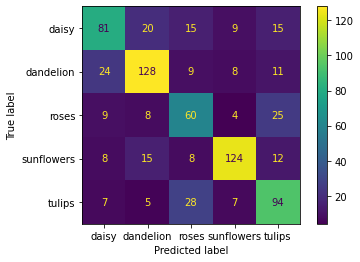

In [71]:
cm = metrics.confusion_matrix(predictions, true_categories)
metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_names).plot()

In [72]:
print(metrics.classification_report(predictions, true_categories))

              precision    recall  f1-score   support

       daisy       0.63      0.58      0.60       140
   dandelion       0.73      0.71      0.72       180
       roses       0.50      0.57      0.53       106
  sunflowers       0.82      0.74      0.78       167
      tulips       0.60      0.67      0.63       141

    accuracy                           0.66       734
   macro avg       0.65      0.65      0.65       734
weighted avg       0.67      0.66      0.67       734



## Adding in DropOut Layers

In [73]:
num_classes = 5

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Rescaling(1./255))
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(num_classes))

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [74]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [75]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=600, 
    use_multiprocessing = True,
    callbacks=[early_stop]
)

Epoch 1/600
92/92 [==============================] - 8s 86ms/step - loss: 2.0964 - accuracy: 0.3001 - val_loss: 1.5297 - val_accuracy: 0.4087
Epoch 2/600
92/92 [==============================] - 8s 85ms/step - loss: 1.2925 - accuracy: 0.4874 - val_loss: 1.4695 - val_accuracy: 0.5123
Epoch 3/600
92/92 [==============================] - 8s 85ms/step - loss: 1.1638 - accuracy: 0.5480 - val_loss: 1.4015 - val_accuracy: 0.4864
Epoch 4/600
92/92 [==============================] - 8s 85ms/step - loss: 0.9697 - accuracy: 0.6379 - val_loss: 1.3328 - val_accuracy: 0.4646
Epoch 5/600
92/92 [==============================] - 8s 85ms/step - loss: 0.8250 - accuracy: 0.7033 - val_loss: 1.2549 - val_accuracy: 0.5286
Epoch 6/600
92/92 [==============================] - 8s 85ms/step - loss: 0.6836 - accuracy: 0.7626 - val_loss: 1.2218 - val_accuracy: 0.5218
Epoch 7/600
92/92 [==============================] - 8s 85ms/step - loss: 0.5409 - accuracy: 0.8123 - val_loss: 1.1826 - val_accuracy: 0.5259
Epoch 

## Evaluation

In [76]:
model.history.history

{'loss': [2.0963780879974365,
  1.292545199394226,
  1.1638096570968628,
  0.9696871638298035,
  0.8250482082366943,
  0.6835985779762268,
  0.5409351587295532,
  0.48268601298332214,
  0.3795171082019806,
  0.3526163399219513,
  0.29598844051361084,
  0.2514607310295105,
  0.21073371171951294,
  0.19943614304065704,
  0.17165453732013702,
  0.15929384529590607,
  0.1309937685728073,
  0.12379540503025055,
  0.13699065148830414,
  0.13085608184337616,
  0.10894984006881714,
  0.1334395855665207,
  0.10754641890525818,
  0.0835426077246666,
  0.10740464180707932,
  0.06807129830121994,
  0.08969264477491379,
  0.09524068236351013,
  0.07783374190330505,
  0.08711294829845428,
  0.06690133363008499,
  0.06596874445676804,
  0.0641140416264534,
  0.10168472677469254,
  0.07284549623727798,
  0.05938807874917984,
  0.06086026132106781,
  0.07736925035715103,
  0.06108752638101578],
 'accuracy': [0.30006811022758484,
  0.48739781975746155,
  0.5480245351791382,
  0.6379427909851074,
  0.703

<AxesSubplot:>

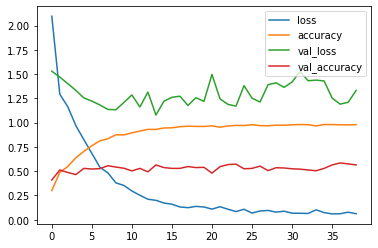

In [77]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [78]:
model.metrics_names

['loss', 'accuracy']

In [79]:
training_score = model.evaluate(train_ds,verbose=1)
test_score = model.evaluate(val_ds,verbose=1)

23/23 [==============================] - 0s 16ms/step - loss: 1.3318 - accuracy: 0.5640


In [80]:
print(training_score)
print(test_score)

[0.25451213121414185, 0.9189373254776001]
[1.3318371772766113, 0.5640326738357544]


In [81]:
predictions = model.predict(val_ds)

In [82]:
predictions

array([[-1.9613487 ,  3.1522057 , -1.8285307 , -1.0906991 , -1.201049  ],
       [ 0.12352389,  1.3206892 , -1.4028292 ,  0.958755  ,  0.9062167 ],
       [-0.7633097 ,  0.7904243 , -1.5095334 ,  0.84624755, -0.23518202],
       ...,
       [-1.1212128 ,  1.8681772 , -0.3949269 , -0.88678336, -1.174807  ],
       [ 2.651738  ,  2.4256442 , -3.0523152 , -2.2341626 , -0.47845277],
       [-0.84172577,  2.1358724 , -0.7649252 , -1.1245666 , -0.94702   ]],
      dtype=float32)

In [83]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [84]:
predictions = pd.Series(np.argmax(predictions,axis=1))

In [85]:
predictions

0      1
1      1
2      3
3      0
4      1
      ..
729    1
730    4
731    1
732    0
733    1
Length: 734, dtype: int64

In [86]:
predictions = pd.Series(predictions).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)

In [87]:
predictions

0       dandelion
1       dandelion
2      sunflowers
3           daisy
4       dandelion
          ...    
729     dandelion
730        tulips
731     dandelion
732         daisy
733     dandelion
Length: 734, dtype: object

In [88]:
true_categories = tf.concat([y for x, y in val_ds], axis=0).numpy()

In [89]:
true_categories

array([0, 4, 3, 0, 3, 4, 1, 2, 4, 0, 0, 0, 4, 4, 4, 3, 3, 0, 0, 3, 1, 4,
       4, 2, 3, 3, 1, 2, 1, 2, 4, 1, 1, 0, 2, 2, 3, 1, 3, 4, 2, 3, 4, 4,
       3, 4, 4, 3, 4, 1, 4, 1, 4, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 1, 3, 1,
       0, 3, 4, 1, 0, 2, 3, 0, 3, 1, 0, 0, 3, 0, 4, 2, 3, 1, 4, 3, 1, 4,
       2, 1, 1, 0, 1, 2, 4, 2, 0, 2, 4, 3, 2, 1, 1, 2, 0, 0, 1, 4, 3, 0,
       4, 2, 0, 0, 0, 1, 0, 4, 4, 4, 0, 4, 4, 3, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 3, 0, 3, 4, 2, 3, 0, 3, 2, 2, 3, 2, 4, 3, 4, 0, 4, 2, 2, 0,
       2, 1, 0, 3, 2, 3, 0, 2, 4, 3, 0, 2, 3, 3, 4, 0, 1, 2, 3, 0, 4, 3,
       3, 1, 3, 2, 3, 1, 1, 2, 1, 4, 0, 1, 3, 3, 2, 2, 4, 1, 3, 1, 4, 1,
       1, 0, 1, 4, 3, 1, 1, 3, 3, 4, 1, 1, 0, 4, 1, 1, 1, 1, 3, 4, 3, 0,
       2, 2, 1, 4, 1, 1, 3, 1, 0, 0, 4, 4, 0, 1, 4, 3, 4, 4, 0, 2, 3, 3,
       3, 4, 0, 2, 4, 1, 1, 0, 1, 0, 3, 3, 4, 2, 0, 3, 4, 4, 1, 0, 2, 4,
       0, 2, 4, 4, 3, 1, 4, 2, 3, 3, 3, 3, 3, 1, 4, 4, 3, 2, 2, 3, 3, 0,
       3, 1, 1, 4, 4, 1, 4, 4, 3, 4, 0, 1, 1, 2, 0,

In [90]:
true_categories = pd.Series(true_categories).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)

In [91]:
true_categories

0           daisy
1          tulips
2      sunflowers
3           daisy
4      sunflowers
          ...    
729        tulips
730        tulips
731        tulips
732         daisy
733     dandelion
Length: 734, dtype: object

In [92]:
metrics.accuracy_score(predictions, true_categories)

0.5640326975476839

In [93]:
metrics.confusion_matrix(predictions, true_categories)

array([[ 45,   6,   4,   4,   8],
       [ 75, 164,  39,  56,  42],
       [  3,   1,  38,   0,  22],
       [  0,   3,   2,  90,   8],
       [  6,   2,  37,   2,  77]], dtype=int64)

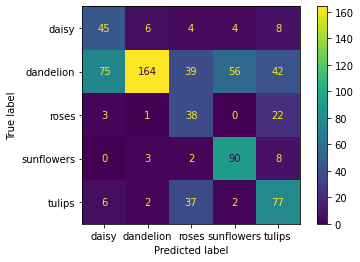

In [94]:
cm = metrics.confusion_matrix(predictions, true_categories)
metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=class_names).plot()

In [95]:
print(metrics.classification_report(predictions, true_categories))

              precision    recall  f1-score   support

       daisy       0.35      0.67      0.46        67
   dandelion       0.93      0.44      0.59       376
       roses       0.32      0.59      0.41        64
  sunflowers       0.59      0.87      0.71       103
      tulips       0.49      0.62      0.55       124

    accuracy                           0.56       734
   macro avg       0.54      0.64      0.54       734
weighted avg       0.70      0.56      0.57       734



# Despliegue

In [96]:
sunflowers = os.listdir(data_dir+'/sunflowers')
sunflowers = [data_dir + '/sunflowers/' + flower for flower in sunflowers] 

dandelion = os.listdir(data_dir+'/dandelion')
dandelion = [data_dir + '/dandelion/' + flower for flower in dandelion] 

roses = os.listdir(data_dir+'/roses')
roses = [data_dir + '/roses/' + flower for flower in roses] 

daisy = os.listdir(data_dir+'/daisy')
daisy = [data_dir + '/daisy/' + flower for flower in daisy] 

tulips = os.listdir(data_dir+'/tulips')
tulips = [data_dir + '/tulips/' + flower for flower in tulips] 

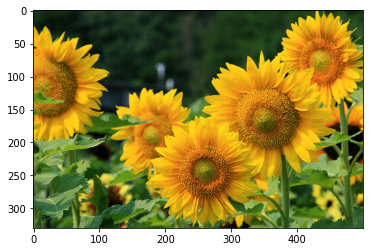

In [102]:
plt.imshow(imread(sunflowers[0]))

In [108]:
path = dandelion[0]
image = load_img(path, target_size=(img_height, img_width))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = tf.keras.applications.imagenet_utils.preprocess_input(image_array)
predictions = model.predict(image_array)
predictions = pd.Series(np.argmax(predictions,axis=1))
predictions = pd.Series(predictions).replace(np.linspace(0,len(class_names)-1, len(class_names)), class_names)
print(predictions.values[0])

dandelion


In [99]:
final = datetime.datetime.today()

In [100]:
tiempo_transcurrido = final - inicio
print(tiempo_transcurrido.seconds)
print(tiempo_transcurrido.seconds/60)

4628
77.13333333333334


In [101]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']